In [1]:
!pip install -q --upgrade pip
!pip install -q --upgrade numpy
!pip install -q --upgrade scipy
!pip install -q --upgrade matplotlib
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import glob
import os
from scipy.signal import find_peaks
from scipy.signal import butter, filtfilt, iirfilter, freqs, lfilter, lfilter_zi
import json

DEPRECATION: distro-info 1.1build1 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: distro-info 1.1build1 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: distro-info 1.1build1 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be fou

In [2]:
logFilePath = "../../../logs"

In [3]:
def findLatestLogFile():
    list_of_files = glob.glob(os.path.join(logFilePath, '*.log'))
    latest_file = max(list_of_files, key=os.path.getctime)
    print("Latest file: ", latest_file)
    return latest_file

In [4]:
def readADCData(logfile):
    # Each line is formatted like this:
    # T 60588.800 2301 2009 2015 2003 2311.97 60598192 1820.18 60588739 RMS 4.43 ZXT 60587477 mean 2165.00 last-mean -124.00

    # Log data
    timestamps = []
    adc_values = []
    peak_values = []
    rms = []
    zxt = []
    mean = []
    last_mean = []

    # Read the file
    with open(logfile) as f:
        lines = f.readlines()

        # Iterate over each line
        for line in lines:

            # Check if the line is a sample
            if "T " in line:
                # Extract the timestamp and the ADC value
                parts = line.split(' ')
                timestamps.append(float(parts[1]) * 1000)
                adc_values.append((int(parts[2]), int(parts[3]), int(parts[4]), int(parts[5])))
                peak_values.append((float(parts[6]), int(parts[7]), float(parts[8]), int(parts[9])))
                rms.append(float(parts[11]))
                zxt.append(int(parts[13]))
                mean.append(float(parts[15]))
                last_mean.append(float(parts[17]))

    # Debug
    print("Read", len(timestamps), "samples")

    # Convert to numpy arrays
    timestamps = np.array(timestamps)
    adc_values = np.array(adc_values)
    peak_values = np.array(peak_values)
    rms = np.array(rms)
    zxt = np.array(zxt)
    mean = np.array(mean)
    last_mean = np.array(last_mean)

    # Find indices where changes occur
    zxt = np.where(np.diff(zxt) != 0)[0]

    print(zxt)
    
    return timestamps, adc_values, peak_values, rms, zxt, mean, last_mean

Latest file:  ../../../logs/20240217-192542.log
Read 1400 samples
[  99  199  265  299  353  383  399  423  488  499  517  548  578  599
  610  643  673  699  704  736  768  797  799  828  860  891  899  923
  955  987  999 1018 1050 1082 1099 1112 1140 1172 1199 1209 1234 1265
 1298 1299]


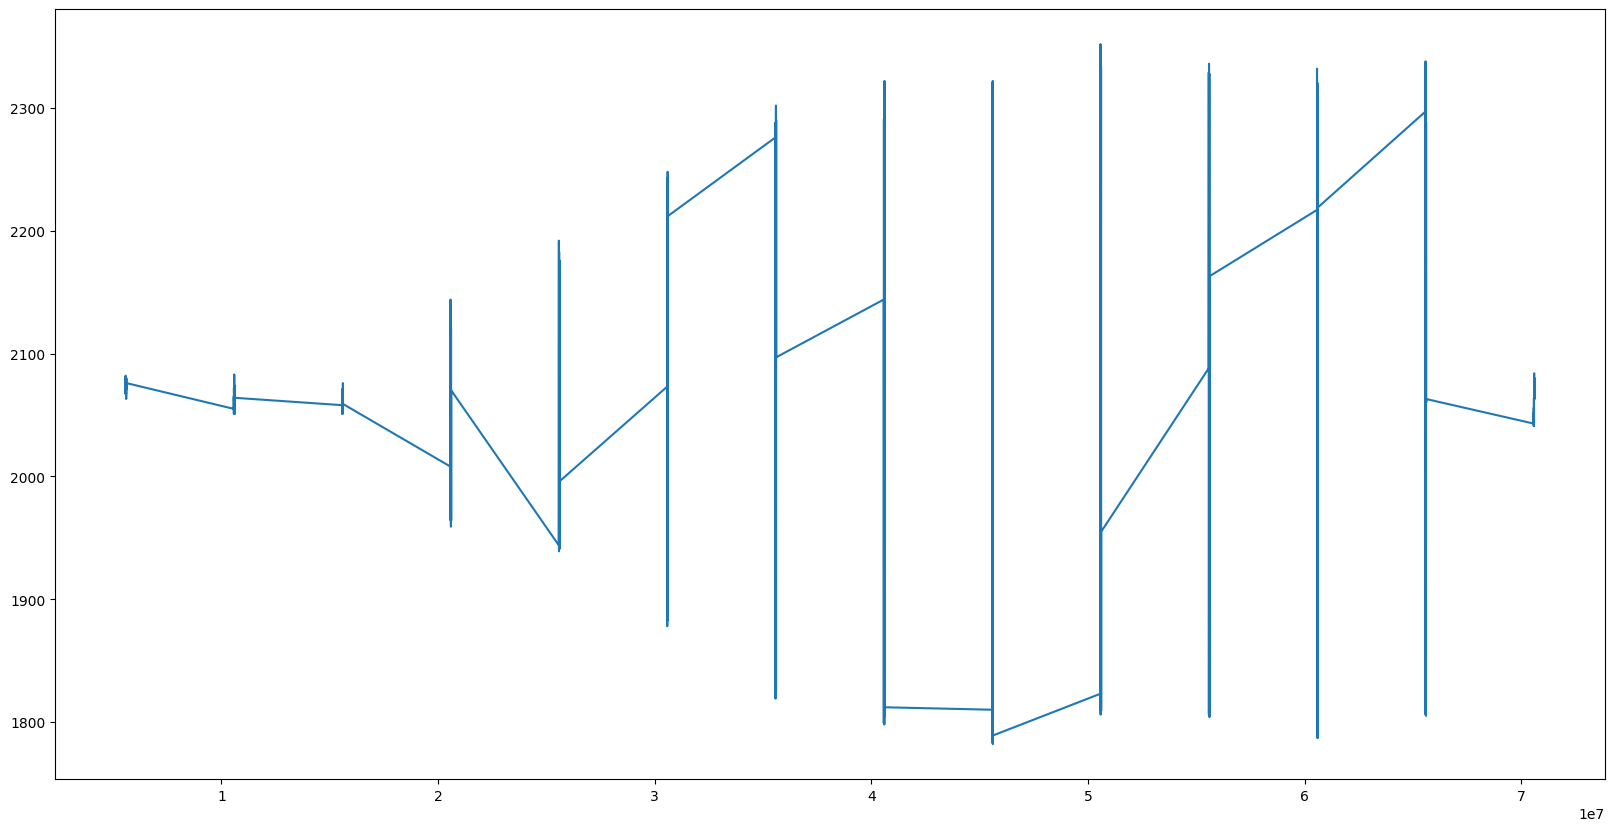

In [5]:
if __name__ == "__main__":

    # Set plot size
    matplotlib.rcParams['figure.figsize'] = [20, 10]
    
    # Find the latest log file
    logfile = findLatestLogFile()

    # Read the data
    timestamps, adc_values, peak_values, rms, zxt, mean, last_mean = readADCData(logfile)

    # Plot the data
    plt.plot(timestamps, adc_values[0:,0], label="Channel 1")

    # Show the plot
    plt.show()

[ 5565400.  5565800.  5566200. ... 70617200. 70617600. 70618000.]
[  99  199  265  299  353  383  399  423  488  499  517  548  578  599
  610  643  673  699  704  736  768  797  799  828  860  891  899  923
  955  987  999 1018 1050 1082 1099 1112 1140 1172 1199 1209 1234 1265
 1298 1299]
[2074.    0. 2074.    0.]


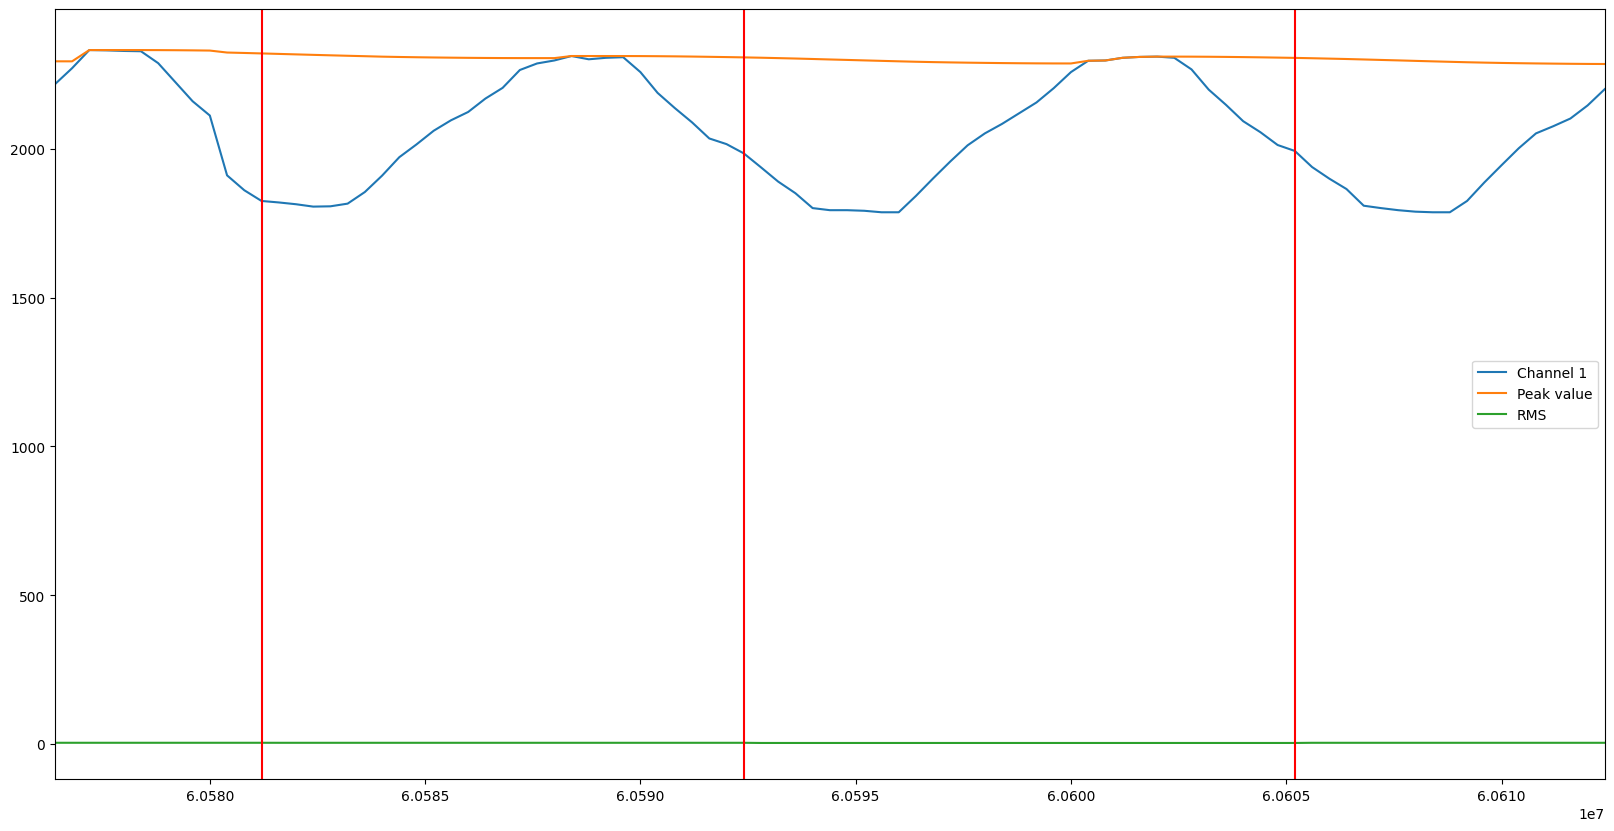

In [6]:
print(timestamps)
print(zxt)
# Plot peak pos adc_ch1
print(peak_values[0])
plt.plot(timestamps, adc_values[0:,0], label="Channel 1")
plt.plot(timestamps, peak_values[0:,0], label="Peak value")

plt.plot(timestamps, rms, label="RMS")

# Plot the zero crossings
for i in range(len(zxt)):
    plt.axvline(x=timestamps[zxt[i]], color='r')

# Show the plot
plt.legend()

plt.xlim([timestamps[1100], timestamps[1190]])
plt.show()

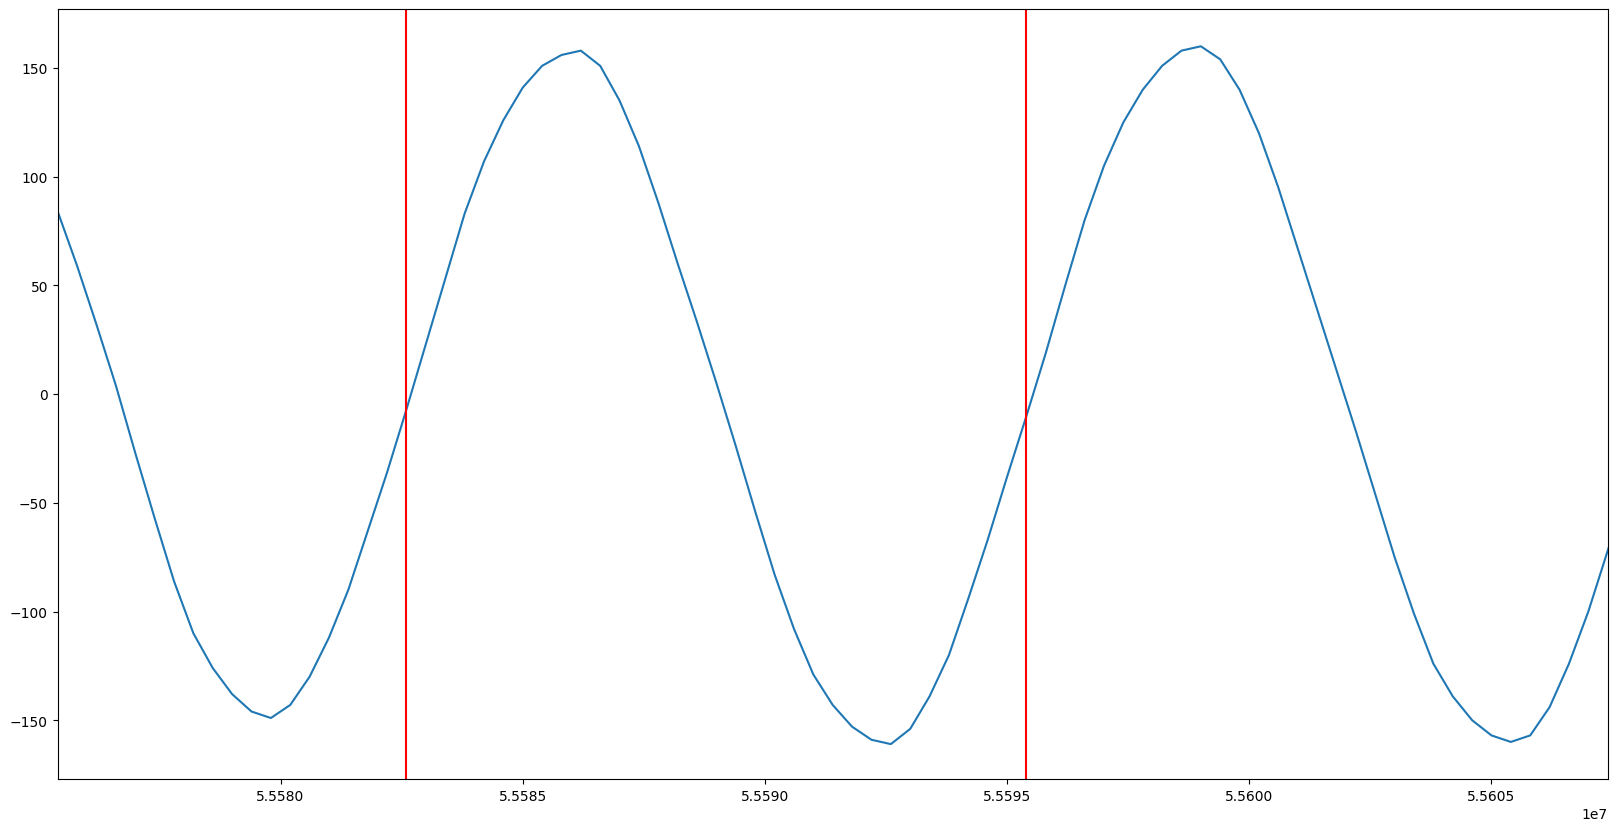

In [7]:
# Plot RMS value and zero crossing time
plt.plot(timestamps, last_mean)
plt.xlim([timestamps[1000], timestamps[1080]])
# Plot the zero crossings
for i in range(len(zxt)):
    plt.axvline(x=timestamps[zxt[i]], color='r')
plt.show()

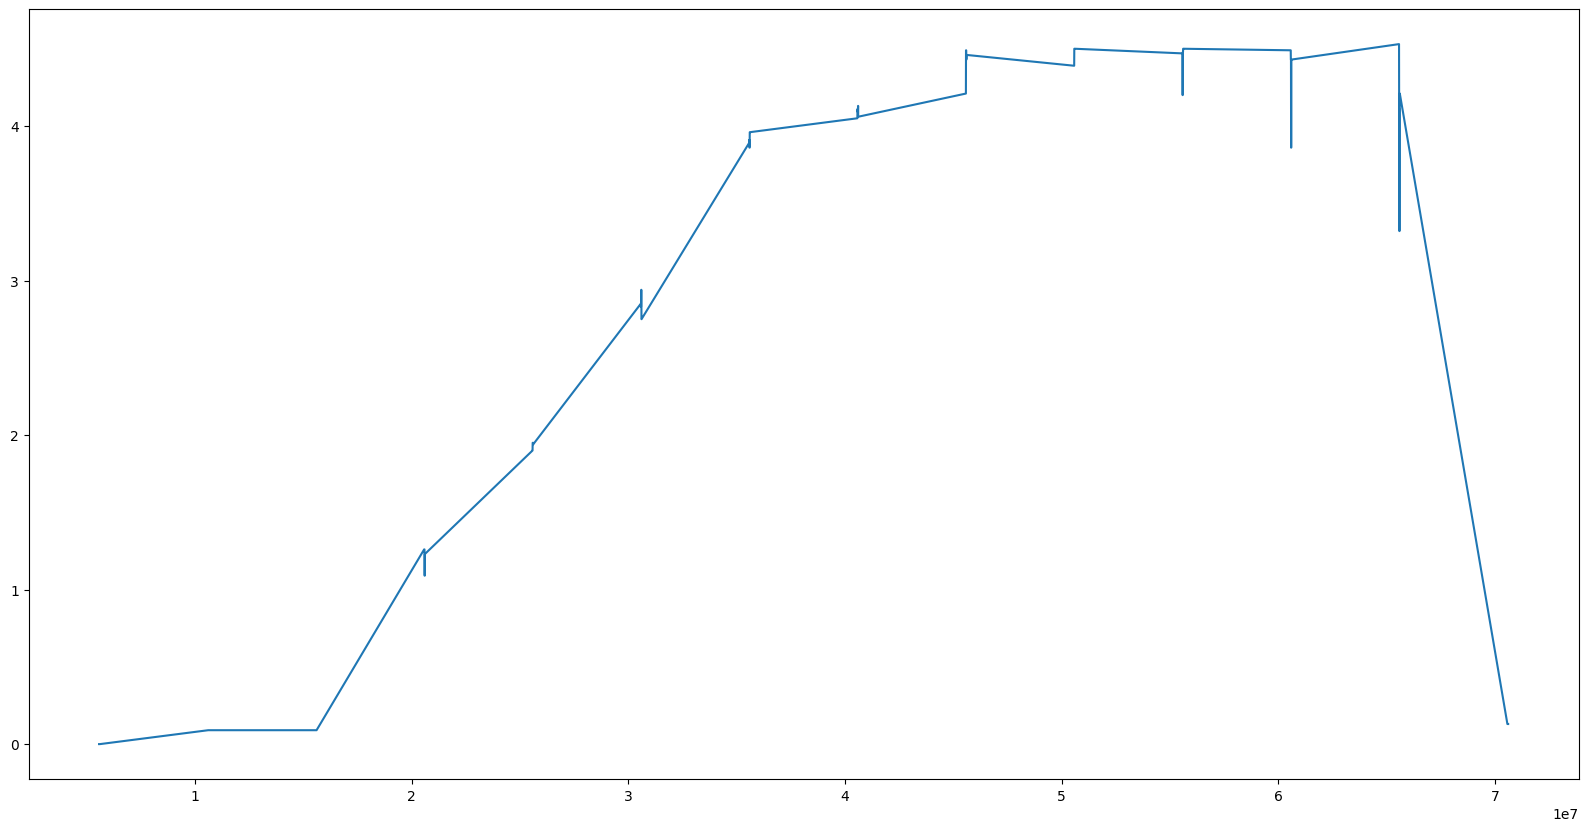

In [8]:
# Plot a chunk of data in a large plot
plt.plot(timestamps, rms)
# plt.xlim([timestamps[1000], timestamps[1480]])
plt.show()

# # Get min and max values in above range
# min_adc = np.min(adc_ch1[1000:1480])
# max_adc = np.max(adc_ch1[1000:1480])
# print("Min ADC: ", min_adc)
# print("Max ADC: ", max_adc)

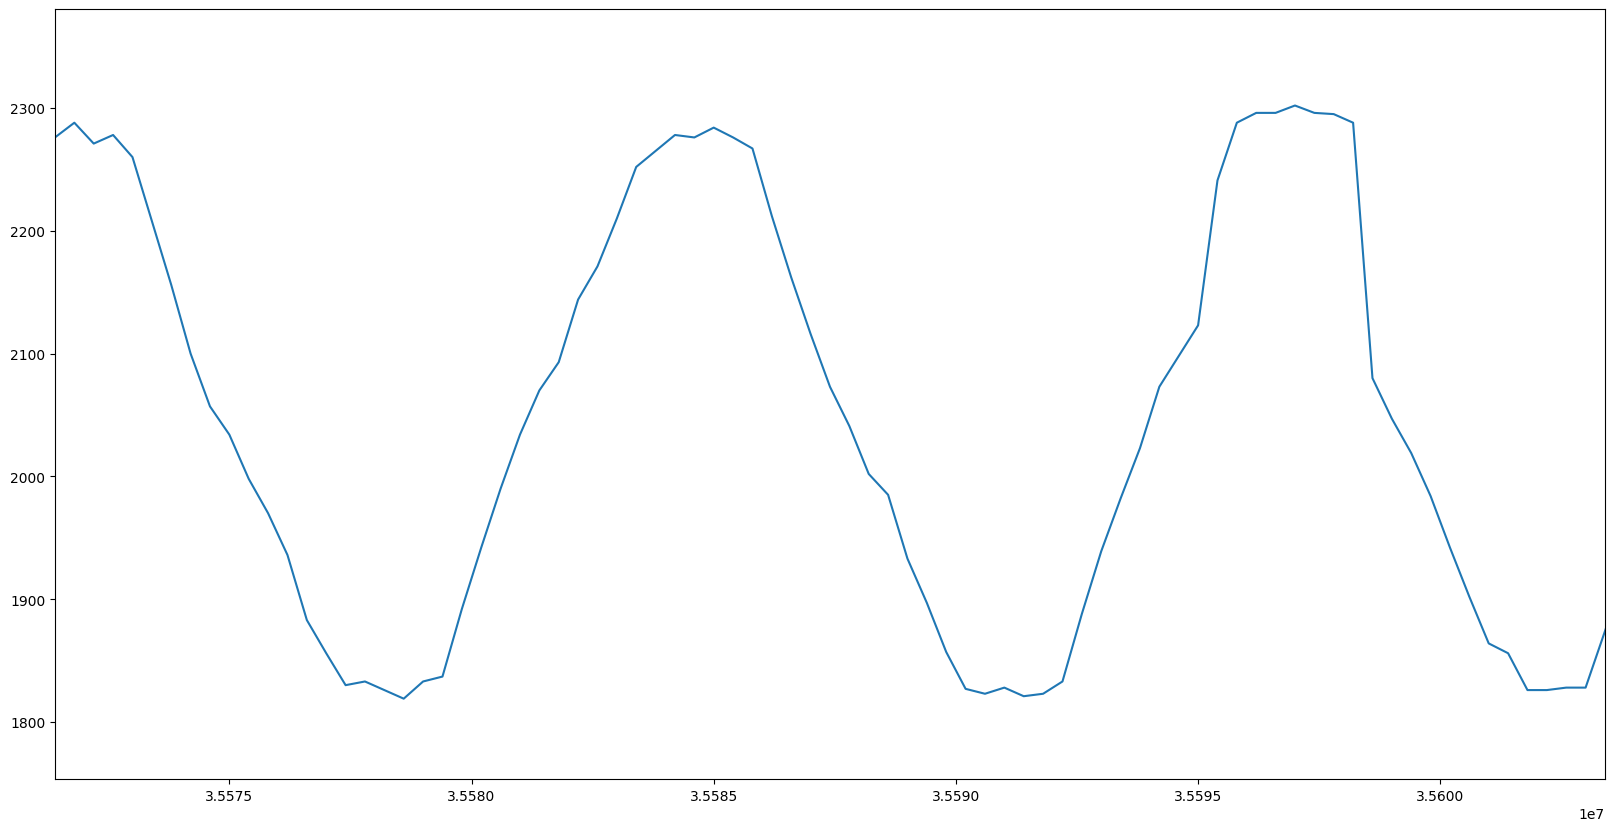

In [9]:
# Plot a chunk of data in a large plot
plt.plot(timestamps, adc_values[0:,0])
plt.xlim([timestamps[600], timestamps[680]])
plt.show()

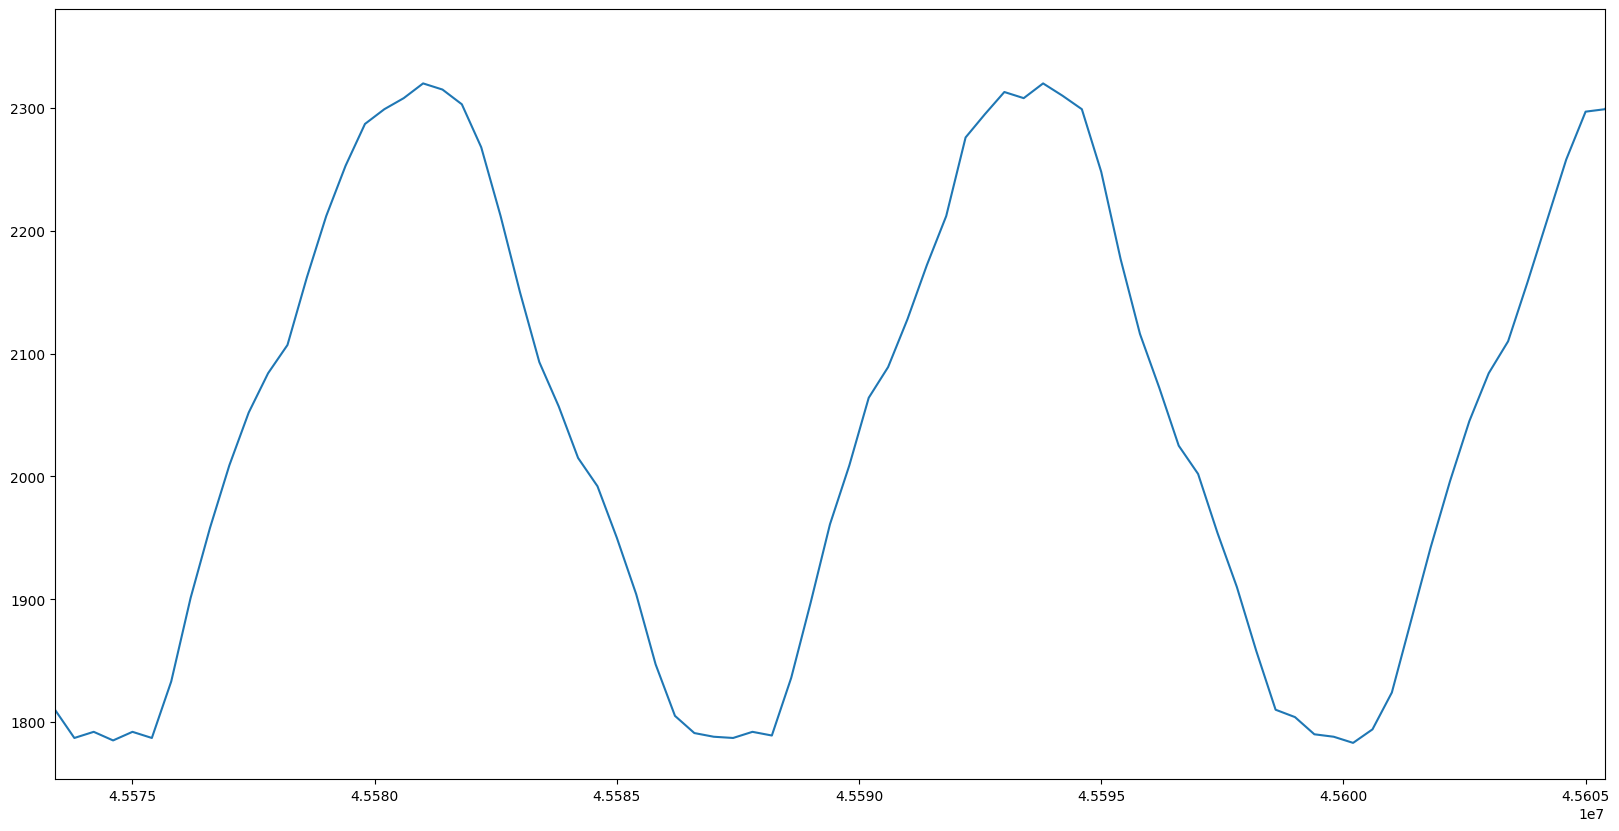

In [11]:
# Plot a chunk of data in a large plot
plt.plot(timestamps, adc_values[0:,0])
plt.xlim([timestamps[800], timestamps[880]])
plt.show()

In [27]:
# Split into batches based on time gaps
time_gaps = np.diff(timestamps)
batch_indices = np.where(time_gaps > 1000)[0]
# Add one to the indices to get the start of the next batch
batch_indices = batch_indices + 1
batch_indices = np.insert(batch_indices, 0, 0)
batch_indices = np.append(batch_indices, len(timestamps))
batches = []
for i in range(len(batch_indices) - 1):
    adc_vals_in_range = adc_values[batch_indices[i]:batch_indices[i+1]]
    # Extract the first element from each tuple
    adc0_in_range = [x[0] for x in adc_vals_in_range]
    batches.append((timestamps[batch_indices[i]:batch_indices[i+1]], adc0_in_range, batch_indices[i], batch_indices[i+1]))

# Extract sample rate from the first batch
sample_rate = 1000000 / np.mean(np.diff(batches[0][0]))
print("Sample rate Hz:", sample_rate)
print(batch_indices)

Sample rate Hz: 2500.0
[   0  100  200  300  400  500  600  700  800  900 1000 1100 1200 1300
 1400]


Found 14 batches
Min distance for peak detect: 22
RMS current: 0.11690273735032897
RMS index: 57
RMS current: 0.20109278356022717
RMS index: 158
RMS current: 0.11775563083057962
RMS index: 235
RMS current: 1.6821972714961324
RMS index: 345
RMS current: 2.3567328651436905
RMS index: 447
RMS current: 3.6500374888231337
RMS index: 541
RMS current: 4.794497134148437
RMS index: 634
RMS current: 5.107434180526965
RMS index: 760
RMS current: 5.507980378945626
RMS index: 851
RMS current: 5.6749356063395116
RMS index: 947
RMS current: 5.2508938630389395
RMS index: 1039
RMS current: 5.654842967599921
RMS index: 1130
RMS current: 5.403707947844702
RMS index: 1226
RMS current: 0.3171931514441628
RMS index: 1385


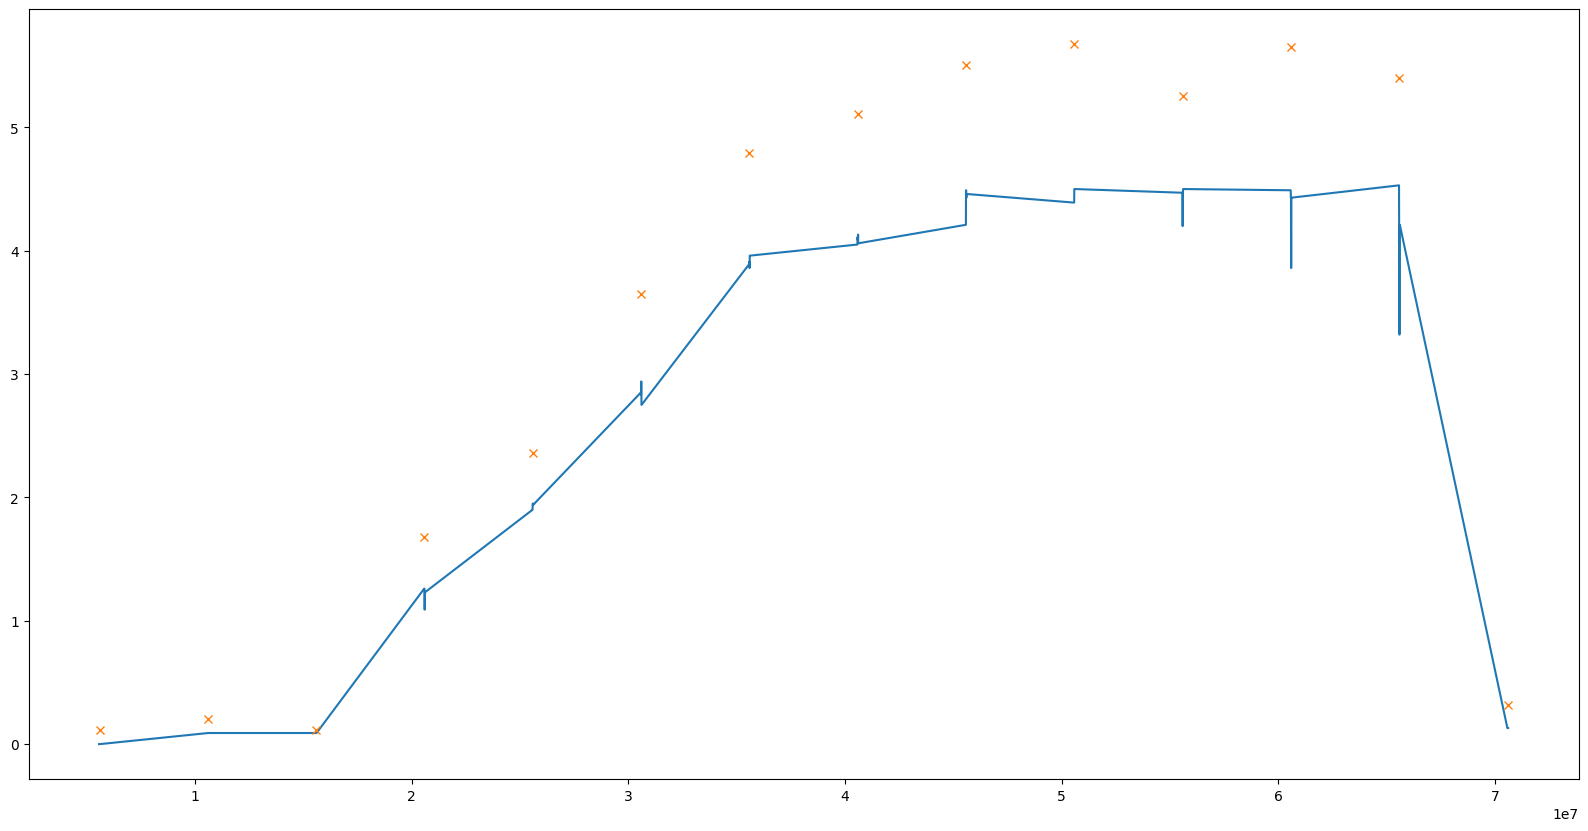

In [28]:
print("Found", len(batches), "batches")

# Signal freq in Hz
signal_freq = 50

# Peak detection min distance
min_distance = int(sample_rate / signal_freq / 2.2)
print("Min distance for peak detect:", min_distance)
rms_calculated = []
rms_indices = []

# Plot the batches
for batch in batches:
    # plt.plot(batch[0], batch[1])
    # plt.show()
    # print("Batch length:", len(batch[0]), "time:", batch[0][0], "to", batch[0][-1])
    # print(batch[0], batch[1])
    # Calculate mean
    mean = np.mean(batch[1])
    # print("Mean:", mean)

    # Calculate current values
    adc_to_current = 0.029
    current = (batch[1] - mean) * adc_to_current

    # # Offset the values
    # batch[1] -= mean

    # # Conversion factor for ADC readings to current
    # batch[1] = batch[1] * adc_to_current

    # # # Plot the batch
    # plt.plot(batch[0], current)
    # plt.show()

    # Find peaks
    peaks, _ = find_peaks(current, height=0.1, distance=min_distance)

    # plt.plot(batch[0], current)
    # plt.plot(batch[0][peaks], current[peaks], "x")
    # plt.show()

    # Check for peaks
    if len(peaks) < 2:
        # print("No peaks found")
        continue

    # Extract the samples between the first and second peak
    first_peak = peaks[0]
    second_peak = peaks[1]
    # print("First peak:", first_peak, "Second peak:", second_peak)
    samples_between_peaks = current[first_peak:second_peak]

    # Plot the samples
    # plt.plot(samples_between_peaks)
    # plt.show()

    # Integrate the samples between the peaks to get the RMS current
    rms_current = np.sqrt(np.mean(samples_between_peaks**2))
    print("RMS current:", rms_current)
    rms_calculated.append(rms_current)
    rms_indices.append(batch[2] + second_peak)
    print("RMS index:", batch[2] + second_peak)

    # # Plot the batch
    # plt.plot(batch[0], current)
    # plt.plot(batch[0][peaks], current[peaks], "x")
    # # Plot the rms_current as a horizontal line
    # plt.axhline(y=rms_current, color='r', linestyle='-')
    # plt.show()
    
plt.plot(timestamps, rms)
plt.plot(timestamps[rms_indices], rms_calculated, "x")
# plt.xlim([timestamps[1000], timestamps[1480]])
plt.show()

